## Quadratic Logistic Model, d-optimal

In [1]:
using Plots
using LinearAlgebra

# projection function onto the design space
function proj(x, design)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    
    a = max.(a,design[1])
    a = min.(a,design[2])
    
    u = sort(b, rev=true)
    j = n
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = b[1:(n-1)]
    
    return [a;b]
end

proj (generic function with 1 method)

In [2]:
#Information matrix for quadratic logistic model
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c = exp(theta[1]+theta[2]*(a[i]-theta[3])^2)
        f = [1,(a[i]-theta[3])^2,2*theta[2]*(theta[3]-a[i]) ]
        mat = mat + b[i] * c/(1+c)^2 * f*f'
    end
    return mat
end

infmat (generic function with 1 method)

In [3]:
function diter()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,k-1)
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = det(infmat(pbest[i,:]))
    end
    gbesth = findmax(pbesth)[1]
    gbest = pbest[findmax(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:],design)
            fit = det(infmat(ptc[j,:]))
            if fit > gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit
            elseif fit > pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path)
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

diter (generic function with 1 method)

In [4]:
theta = [2,3,0]
design = [-3,1]
k = 3
nptc = 128
niter =150

t1 = time()
result = diter()
t2 = time()

1.577290003451629e9

In [5]:
t2-t1

19.848843812942505

In [6]:
result[1]

3-element Array{Float64,1}:
 -0.7269884511799202  
  8.930848545602396e-9
  0.7269884482702005  

In [7]:
result[2]

3-element Array{Float64,1}:
 0.33333333000639936
 0.3333333232640129 
 0.3333333467295878 

In [8]:
theta = [3,-5,0]
design = [-1,1]
k = 4
nptc = 256
niter = 200

t1 = time()
result = diter()
t2 = time()

1.577290007805503e9

In [9]:
result[4]

0.02023431778515892

In [10]:
result[1]

4-element Array{Float64,1}:
  0.9216658923863014
 -0.5920574051956397
 -0.9216658845259343
  0.592057427209701 

In [11]:
result[2]

4-element Array{Float64,1}:
 0.29656360392445863
 0.20343638439662695
 0.296563625702567  
 0.2034363859763474 

In [12]:
repx = zeros(1000,4)
repw = zeros(1000,4)
fopt = zeros(1000)

for i = 1:1000
    result = diter()
    repx[i,:] = result[1]
    repw[i,:] = result[2]
    fopt[i] = result[4]
    print(i)
end

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [13]:
perm = sortperm(fopt)

repx = repx[perm,:]
repw = repw[perm,:]
fopt = fopt[perm]

1000-element Array{Float64,1}:
 0.018228167200968252
 0.018228167200968252
 0.018228167200968252
 0.018228167200968252
 0.018228167200968252
 0.018228167200968256
 0.018228167200968256
 0.018228167200968256
 0.018228167200968256
 0.018228167200968256
 0.01822816720096826 
 0.01822816720096826 
 0.01822816720096826 
 ⋮                   
 0.02023431778515894 
 0.02023431778515894 
 0.02023431778515894 
 0.02023431778515894 
 0.020234317785158943
 0.020234317785158943
 0.020234317785158943
 0.020234317785158943
 0.020234317785158946
 0.02023431778515895 
 0.020234317785158953
 0.020234317785158953

In [37]:
fopt = fopt[perm] .^ (1/3)

1000-element Array{Float64,1}:
 0.26317683992129337
 0.26317683992129337
 0.2663509577942297 
 0.2672461484099442 
 0.27249770908562554
 0.2631768399212932 
 0.2631768399212933 
 0.2631768399212933 
 0.2631768399212933 
 0.2631768399212933 
 0.2631768399212933 
 0.26317683992129337
 0.26317683992129337
 ⋮                  
 0.2631768399212933 
 0.26317683992129337
 0.26317683992129337
 0.26317683992129337
 0.2631768399212933 
 0.26317683992129337
 0.26317683992129337
 0.2724977090856257 
 0.2631768399212934 
 0.26317683992129337
 0.26317683992129326
 0.26724614840994415

In [38]:
using StatsBase
countmap(round.(fopt ./ findmax(fopt)[1],digits=4))

Dict{Float64,Int64} with 4 entries:
  0.9658 => 654
  0.9774 => 146
  0.9807 => 139
  1.0    => 61

In [39]:
repx[[500,700,900,1000],:]

4×4 Array{Float64,2}:
  0.848815  -1.0       -0.57935    1.0     
  0.91144   -0.644359  -1.0        0.608692
 -0.949022   0.850607  -0.542969  -0.942852
  0.592057   0.921666  -0.592057  -0.921666

In [40]:
repw[[500,700,900,1000],:]

4×4 Array{Float64,2}:
 0.333333  0.333333  0.333333  0.0        
 0.289106  0.258604  0.279489  0.1728     
 0.333333  0.333333  0.333333  2.22045e-16
 0.203436  0.296564  0.203436  0.296564   

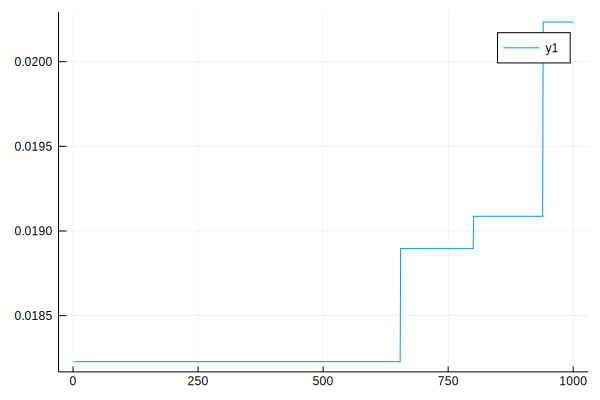

In [15]:
plot(fopt)

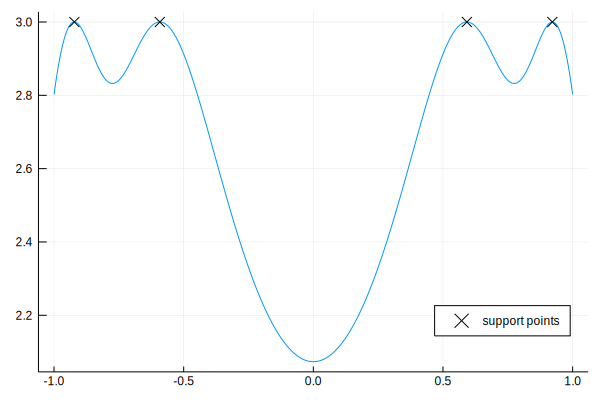

In [20]:
x = repx[1000,:]
w = repw[1000,:]

mat = zeros(3,3)
for i = 1:length(x)
    c = exp(theta[1]+theta[2]*(x[i]-theta[3])^2)
    f = [1,(x[i]-theta[3])^2,2*theta[2]*(theta[3]-x[i]) ]
    mat = mat + w[i] * c/(1+c)^2 * f*f'
end
mati = inv(mat)

function equiv(x)
    c = exp(theta[1]+theta[2]*(x-theta[3])^2)
    f = [1,(x-theta[3])^2,2*theta[2]*(theta[3]-x) ]
    val = c/(1+c)^2 * f'*mati*f
    return val
end

dp = design[1]:((design[2]-design[1])/1000):design[2]
plot(dp, equiv.(dp), label="")
scatter!(x,equiv.(x), markershape = :x, label="support points", legend = :bottomright)

In [22]:
repx[1,:]

4-element Array{Float64,1}:
  1.0               
  1.0               
 -0.8488153992010758
  0.5793503680229187

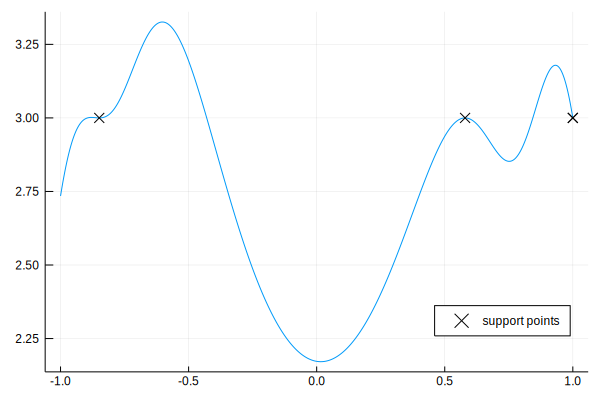

In [21]:
x = repx[1,:]
w = repw[1,:]

mat = zeros(3,3)
for i = 1:length(x)
    c = exp(theta[1]+theta[2]*(x[i]-theta[3])^2)
    f = [1,(x[i]-theta[3])^2,2*theta[2]*(theta[3]-x[i]) ]
    mat = mat + w[i] * c/(1+c)^2 * f*f'
end
mati = inv(mat)

function equiv(x)
    c = exp(theta[1]+theta[2]*(x-theta[3])^2)
    f = [1,(x-theta[3])^2,2*theta[2]*(theta[3]-x) ]
    val = c/(1+c)^2 * f'*mati*f
    return val
end

dp = design[1]:((design[2]-design[1])/1000):design[2]
plot(dp, equiv.(dp), label="")
scatter!(x,equiv.(x), markershape = :x, label="support points", legend = :bottomright)

In [33]:
repx[1,:]

4-element Array{Float64,1}:
  1.0               
  1.0               
 -0.8488153992010758
  0.5793503680229187

In [34]:
repw[1,:]

4-element Array{Float64,1}:
 0.0014793229291951697
 0.33185400589914793  
 0.3333333420905645   
 0.3333333290810925   